<a href="https://colab.research.google.com/github/vieduy/CheXpert/blob/main/CheXpert_HandleImbalanced_WeightedLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Feb 23 02:02:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import library

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [28]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image, ImageOps

In [9]:
cd drive/MyDrive/CheXpert-v1.0

/content/drive/.shortcut-targets-by-id/1-RDgNs_TCBkE_HeXI4VdP0dIXvWo9nXH/CheXpert-v1.0


## Training model

In [11]:
# read train.csv

train_data = pd.read_csv("./train_df.csv", index_col=0)
train_data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
5252,40db43057f32f22dacd78f2415b142c2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6228,4da6d92e1eeeed4658aaa52ce11fe8f4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3975,3156b5feb62ed8cfdafef21f1f82a6c1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2127,1aebe196c344ddae48ec99b142bcf4c2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11986,942d83991819c4e1c9f10261e7e740cf,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,8c000de5f90b8dd6ed6f77923874c20e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11964,93ceed16504fa1891d00eada288a4c5f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5390,427693347c93b01e186e65ddabcc01b0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
860,0aad4ac2ea24742e3f9de3d29fae6d95,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
val_data = pd.read_csv("./val_df.csv", index_col=0)
val_data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
19517,f0267345c2bb297314f8c9db2b33ffb2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19536,f0779544e2abbf51d3ac17e208ff29df,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18938,e925b5b0b88c9d5cfbced3b3552fa456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12315,986a142a1300b3401bdeda43822ceba6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6267,4e1c7c8139ca923967f318edb0fec0e6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18334,e1a4353d3e747a7150cb06cac73f4d6f,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,78ea1df200023de69c0cf9d0c8a28658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19112,eb6c714df22142229464c6b83e47d7d6,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7014,575c1973c2d617658508d18d94bc2ffa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# Get label names

LABELS = train_data.columns[1:]
LABELS

Index(['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
       'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
       'Other lesion', 'Pleural effusion', 'Pleural thickening',
       'Pneumothorax', 'Pulmonary fibrosis', 'No Finding'],
      dtype='object')

In [29]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] 
        self.image_labels = []
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ]
        
        if normalization:
            # Normalization with mean and std from ImageNet
            image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, 'train/'+row.image_id+'.png')
            self.image_paths.append(image_path)
            labels = []
            for col in row[1:]:
                if col == 1:
                    labels.append(1)
                else:
                    labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        image_data = ImageOps.autocontrast(image_data, cutoff=3)
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

In [30]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 96                              
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100

In [31]:
train_dataset = ChestXrayDataset(".", train_data, IMAGE_SIZE, True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [32]:
val_dataset = ChestXrayDataset(".", val_data, IMAGE_SIZE, True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

### Init model

In [33]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Linear(kernel_count, num_classes)
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DenseNet121(num_classes=len(LABELS)).to(device)
model

In [35]:
# Loss function
loss_criteria = nn.BCEWithLogitsLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

In [ ]:
!pip install fastprogress==0.1.20

In [36]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = nn.Sigmoid()(y_pred).to("cpu").numpy()
    
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return auroc

In [20]:
# Calculate ratio of positive samples between labels 

features_size=[]
features_data =[]
features_name=[]

for feature in list(train_data.columns[1:16]):
    data_feature = train_data.loc[train_data[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)


objects = list(train_data.columns[1:16])
y_pos = np.arange(len(objects))

# Inverse ratio between labels for weighted loss
weighted = 1.0/(np.array(features_size)/train_data.shape[0])
print(weighted)

[  3.94080338  83.58744395  33.40501792   5.46787914  41.51447661
  36.83794466  22.98397041  10.66361556  16.05512489  13.58600583
  11.01004135   7.02865762 121.03896104   7.27272727   1.95572343]


In [21]:
weighted = torch.tensor(weighted).to(device)

In [37]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation WEIGHTED LOSS
        loss = (loss * weighted).mean()
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

In [38]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)
            loss = (loss * weighted).mean()

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_auroc(out_gt, out_pred)).mean()

### Training

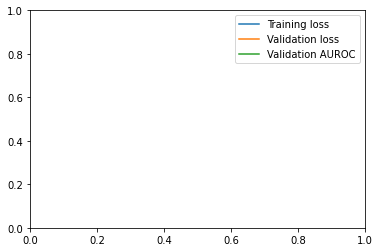

In [ ]:
import time

# Best AUROC value during training
best_score = 0
model_path = "densenet.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation AUROC']
x = []

nonimproved_epoch = 0
start_time = time.time()

# Training each epoch
for epoch in mb:
    mb.main_bar .comment = f'Best AUROC score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    val_loss = val_loss.to("cpu").numpy()
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(val_loss)
    validation_score.append(new_score)

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve AUROC from {best_score} to {new_score}")
        best_score = new_score
        nonimproved_epoch = 0
        torch.save({"model": model.state_dict(), 
                    "optimizer": optimizer.state_dict(), 
                    "best_score": best_score, 
                    "epoch": epoch, 
                    "lr_scheduler": lr_scheduler.state_dict()}, model_path)
    else: 
        nonimproved_epoch += 1
    if nonimproved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - start_time > 3600*8:
        break
        print("Out of time")